<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C2/C2.html"><img src="../data/C2_nav.png" width="100"  style="float:right;" alt="C2"></a>
<h1> STFT: Padding</h1> 
</div>

<br/>

<p>
In this notebook, we discuss various padding strategies that become important when implementing and interpreting an STFT. For details on the STFT, we refer to Section 2.1.4 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a> and the <a href="../C2/C2_STFT-Basic.html">notebook on STFT Basics.</a>
</p> 

## Padding Variants

When using the STFT with window size $N\in\mathbb{N}$, two aspects of padding can be considered:

1. The center of the first window corresponds to the signal's sample index $N/2$. However, often it is convenient to think of the first window corresponding to the time of $0$. To achieve this, one can pad $N/2$ samples at the beginning of the signal.

2. The last window's time range is fully contained in the signal's time range. Therefore, the end of the signal is not covered by as many overlapping windows as the rest of the signal. To counteract this, one can use padding at the end of the signal. The exact amount of necessary padding depends on the hop size as well as the window size. However, for practical reasons, one often just uses a padding length of $N/2$ again.

One padding strategy is to expand the signal with zeros (**zero padding**). A different strategy is to expand the signal with samples by mirroring the signal on the first and last sample, respectively (**reflect padding**). Several other padding strategies are described in the documentation of [`numpy.pad`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.pad.html). The following example illustrates several padding strategies using a simple example.

No padding:


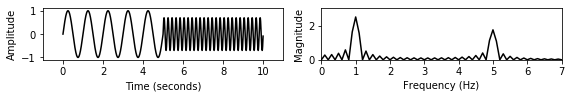

Zero padding:


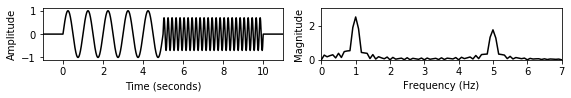

Reflect padding:


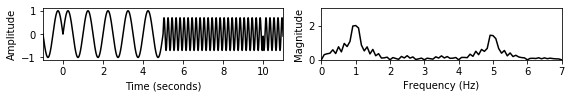

In [1]:
import numpy as np
from  matplotlib import pyplot as plt
import librosa
from ipywidgets import interact, fixed, FloatSlider
%matplotlib inline

Fs = 256
duration = 10
omega1 = 1
omega2 = 5
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

def pad_and_plot(t, x, Fs, pad_len_sec, pad_mode):
    
    pad_len = int(pad_len_sec * Fs)
    
    t = np.concatenate((np.arange(-pad_len, 0) / Fs, t, 
                        np.arange(len(x), len(x) + pad_len) / Fs))
    x = np.pad(x, pad_len, pad_mode)
    N = len(x)
        
    plt.figure(figsize=(8, 1.5))
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(t, x, c='k')
    #plt.xlim([t[0], t[-1]])
    plt.xlim([-1.0, 11.0])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')

    ax2 = plt.subplot(1, 2, 2)
    X = np.abs(np.fft.fft(x)) / Fs
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    plt.plot(freq, X, c='k')
    plt.xlim([0, 7])
    plt.ylim([0, 3])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.show()
    
    return ax1, ax2
    
print('No padding:')
ax1, ax2 = pad_and_plot(t, x, Fs, 0.0, 'constant')

print('Zero padding:')
ax1, ax2 = pad_and_plot(t, x, Fs, 1.0, 'constant')

print('Reflect padding:');
ax1, ax2 = pad_and_plot(t, x, Fs, 1.0, 'reflect')

#print('Interactive interface for experimenting with different padding variants:')
#interact(pad_and_plot,
#         t=fixed(t), x=fixed(x), Fs=fixed(Fs),
#         pad_len_sec=FloatSlider(min=0, max=duration/2, step=0.1, 
#                continuous_update=False, value=1.0, description='Pad Length'),
#         pad_mode = ['constant',
#                     'edge',
#                     'linear_ramp',
#                     'maximum',
#                     'mean',
#                     'median',
#                     'minimum',
#                     'reflect',
#                     'symmetric',
#                     'wrap']);

## Edge Phenomena

Using different padding strategies, the beginning and end of the corresponding spectrograms will be different. When using a hop size smaller than $N/2$, more than one frame will be affected at both beginning and end. The following visualizations illustrate those **edge phenomena**. (Note that in the following visualizations, matrices are aligned; only colored regions correspond to existing frames for the padding strategy considered.)

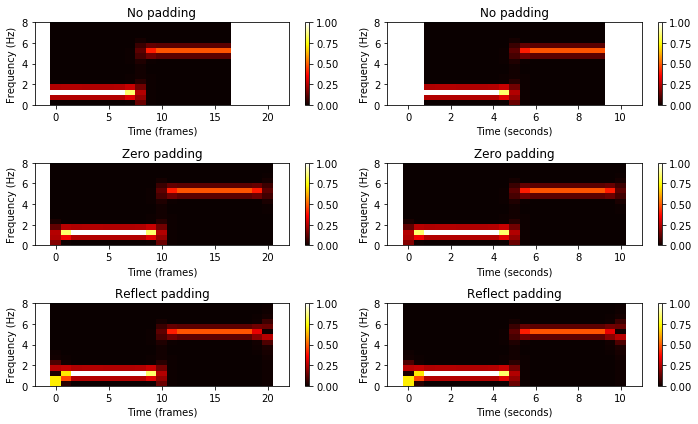

In [2]:
def compute_stft(x, Fs, N, H, pad_mode='constant', center=True, color='gray_r'):    
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, 
                     window='hann', pad_mode=pad_mode, center=center)
    Y = np.abs(X) ** 2
    Y = Y / np.max(Y)
    return Y

def plot_stft(Y, Fs, N, H, time_offset=0, time_unit='frames', xlim=None, ylim=None, title='', xlabel='', color='hot'):
    time_samples =  np.arange(Y.shape[1])
    if time_unit == 'sec':
        time_sec = np.arange(Y.shape[1]) * (H / Fs) + time_offset
        extent=[time_sec[0]-H/(2*Fs), time_sec[-1]+H/(2*Fs), 0, Fs/2]
        xlabel='Time (seconds)'
    else:
        time_samples = np.arange(Y.shape[1])
        extent=[time_samples[0]-1/2, time_samples[-1]+1/2, 0, Fs/2]                     
        xlabel='Time (frames)'    
    plt.imshow(Y, cmap=color , aspect='auto', origin='lower', extent=extent)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.colorbar()

N = 512
H = 128
xlim_frame = [-2, 22]
xlim_sec = [-1, 11]
ylim_hz = [0, 8]

plt.figure(figsize=(10, 6))

# No padding
Y = compute_stft(x, Fs, N, H, pad_mode=None, center=False)
plt.subplot(3, 2, 1)
plot_stft(Y, Fs, N, H, xlim=xlim_frame, ylim=ylim_hz, title='No padding')

plt.subplot(3, 2, 2)
plot_stft(Y, Fs, N, H, time_offset=N / (2 * Fs), time_unit='sec', xlim=xlim_sec, ylim=ylim_hz, title='No padding')

# Zero padding
Y = compute_stft(x, Fs, N, H, pad_mode='constant', center=True)
plt.subplot(3, 2, 3)
plot_stft(Y, Fs, N, H, xlim=xlim_frame, ylim=ylim_hz, title='Zero padding')

plt.subplot(3, 2, 4)
plot_stft(Y, Fs, N, H, time_unit='sec', xlim=xlim_sec, ylim=ylim_hz, title='Zero padding')

# Reflect padding
Y = compute_stft(x, Fs, N, H, pad_mode='reflect', center=True)
plt.subplot(3, 2, 5)
plot_stft(Y, Fs, N, H, xlim=xlim_frame, ylim=ylim_hz, title='Reflect padding')

plt.subplot(3, 2, 6)
time_sec = np.arange(Y.shape[1]) * (H / Fs) 
plot_stft(Y, Fs, N, H, time_unit='sec', xlim=xlim_sec, ylim=ylim_hz, title='Reflect padding')

plt.tight_layout()

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a>.
</div>

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>